<img width="200" src="https://raw.githubusercontent.com/lukwies/mid-bootcamp-project/main/data/img/bikes.png">

---


# Bikesharing in Seoul / Prediction

---

### Sources

 * Data: https://archive.ics.uci.edu/ml/datasets/Seoul+Bike+Sharing+Demand
 * Image: https://global.chinadaily.com.cn/a/201801/25/WS5a69cab3a3106e7dcc136a6d.html

---

### Tasks

 

In [1]:
import pandas as pd
import numpy as np
import yaml
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, PowerTransformer, MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score

#### Load YAML config file

In [2]:
with open('../params.yaml') as file:
    config = yaml.safe_load(file)

#### Load cleaned dataset

In [3]:
df = pd.read_csv(config['data']['csv_cleaned'])

#### Let's drop column date since we don't need it for prediction

In [4]:
df = df.drop(['date', 'daytime', 'seasons',
              'functioning_day', 'temperature_type',
              'solar_radiation'], axis=1)

### Do X/y-split

In [5]:
X = df.drop(['rented_bike_count'], axis=1)
y = df['rented_bike_count']

### Do train/test-split

In [6]:
X_train,X_test,y_train,y_test = train_test_split(X, y,
                                                 test_size=config['testsplit']['test_size'],
                                                 random_state=config['testsplit']['random_state'])

#### Split train/test set into numerical and categorical columns

In [7]:
X_train_num = X_train.select_dtypes(np.number)
X_train_cat = X_train.select_dtypes(object)

In [8]:
X_test_num = X_test.select_dtypes(np.number)
X_test_cat = X_test.select_dtypes(object)

<br>

### Apply OneHotEncoder on categorical columns

In [9]:
ohe = OneHotEncoder(drop='first')
ohe.fit(X_train_cat)

X_train_cat_enc = ohe.transform(X_train_cat).toarray()
X_test_cat_enc  = ohe.transform(X_test_cat).toarray()

X_train_cat_enc = pd.DataFrame(X_train_cat_enc, columns=ohe.get_feature_names_out(), index=X_train_cat.index)
X_test_cat_enc  = pd.DataFrame(X_test_cat_enc, columns=ohe.get_feature_names_out(), index=X_test_cat.index)

#### Store OneHotEncoder to file

In [10]:
with open(config['encoder']['onehot'], 'wb') as file:
    pickle.dump(ohe, file, pickle.HIGHEST_PROTOCOL)

<br>

### Apply StandardScaler to numerical columns

In [11]:
stdScaler = StandardScaler()
stdScaler.fit(X_train_num)

X_train_num_scaled = stdScaler.transform(X_train_num)
X_train_num_scaled = pd.DataFrame(X_train_num_scaled, columns=X_train_num.columns, index=X_train_num.index)

X_test_num_scaled = stdScaler.transform(X_test_num)
X_test_num_scaled = pd.DataFrame(X_test_num_scaled, columns=X_test_num.columns, index=X_test_num.index)

#### Store StandardScaler to file

In [12]:
with open(config['scaler']['standard'], 'wb') as file:
    pickle.dump(stdScaler, file, pickle.HIGHEST_PROTOCOL)

<br>

### Apply MinMaxScaler to numerical columns

In [13]:
minmax = MinMaxScaler()
minmax.fit(X_train_num_scaled)

X_train_num_scaled = minmax.transform(X_train_num_scaled)
X_train_num_scaled = pd.DataFrame(X_train_num_scaled, columns=X_train_num.columns, index=X_train_num.index)

X_test_num_scaled = minmax.transform(X_test_num_scaled)
X_test_num_scaled = pd.DataFrame(X_test_num_scaled, columns=X_test_num.columns, index=X_test_num.index)

#### Store MinMaxScaler to file

In [14]:
with open(config['scaler']['minmax'], 'wb') as file:
    pickle.dump(minmax, file, pickle.HIGHEST_PROTOCOL)

#### Build final dataframes

In [15]:
X_train_final = pd.concat([X_train_cat_enc, X_train_num_scaled], axis=1)
X_test_final  = pd.concat([X_test_cat_enc, X_test_num_scaled], axis=1)

<br>

### Apply KNeighborRegression

In [16]:
n_neighbors = 3
knn = KNeighborsRegressor(n_neighbors, weights='distance')
knn.fit(X_train_final, np.log(y_train+1))

KNeighborsRegressor(n_neighbors=3, weights='distance')

#### Store KNN model to file

In [17]:
with open(config['model']['KNN'], 'wb') as file:
    pickle.dump(knn, file, pickle.HIGHEST_PROTOCOL)

<br>

### Validate model

In [18]:
y_train_pred_log = knn.predict(X_train_final)
y_test_pred_log  = knn.predict(X_test_final)

train_score = r2_score(y_train, np.exp(y_train_pred_log)-1)
test_score  = r2_score(y_test,  np.exp(y_test_pred_log)-1)

In [19]:
print(f'Train score: {train_score}')
print(f'Test score: {test_score}')

Train score: 1.0
Test score: 0.721152106457803


#### Undo log-transformation

In [20]:
y_train_pred = np.exp(y_train_pred_log) - 1
y_test_pred  = np.exp(y_test_pred_log) - 1

#### Plot regression line

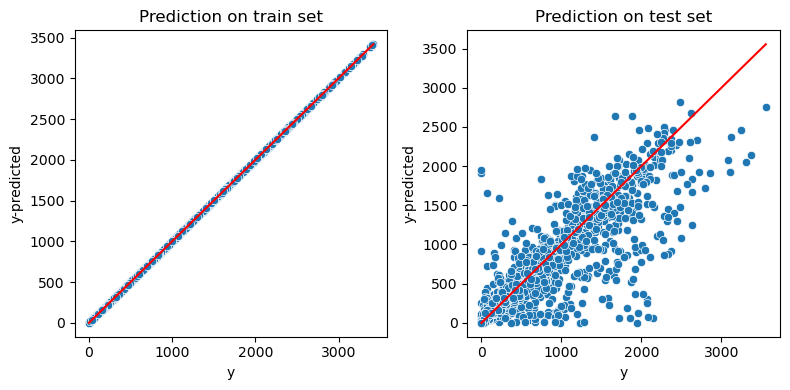

In [21]:
fig,ax = plt.subplots(1, 2, figsize=(8,4))

sx = sns.scatterplot(y=y_train_pred, x=y_train, ax=ax[0])
sx = sns.lineplot(y=y_train, x=y_train, color='red', ax=ax[0])
sx.set(title='Prediction on train set', xlabel='y', ylabel='y-predicted')

sx = sns.scatterplot(y=y_test_pred, x=y_test, ax=ax[1])
sx = sns.lineplot(y=y_test, x=y_test, color='red', ax=ax[1])
sx.set(title='Prediction on test set', xlabel='y', ylabel='y-predicted')

plt.tight_layout()
plt.savefig('../plots/regression_line.png', dpi=300)
plt.show()

As we can see here, our model performs perfectly on the training set but obviously not on the test set.

#### Let's see how our prediction looks on the temperature

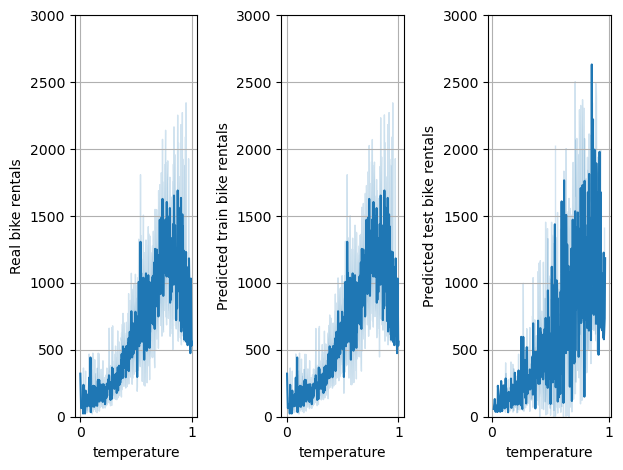

In [22]:
fig,ax = plt.subplots(1,3)

sax = sns.lineplot(data=X_train_final, x='temperature', y=y_train, ax=ax[0])
sax.set(ylabel='Real bike rentals', ylim=(0,3000))
sax.grid()

sax = sns.lineplot(data=X_train_final, x='temperature', y=y_train_pred, ax=ax[1])
sax.set(ylabel='Predicted train bike rentals', ylim=(0,3000))
sax.grid()

sax = sns.lineplot(data=X_test_final, x='temperature', y=y_test_pred, ax=ax[2])
sax.set(ylabel='Predicted test bike rentals', ylim=(0,3000))
sax.grid()

plt.tight_layout()
plt.savefig('../plots/predict_temperature.png', dpi=300)
plt.show()

#### Let's see how our prediction looks on the hour of day

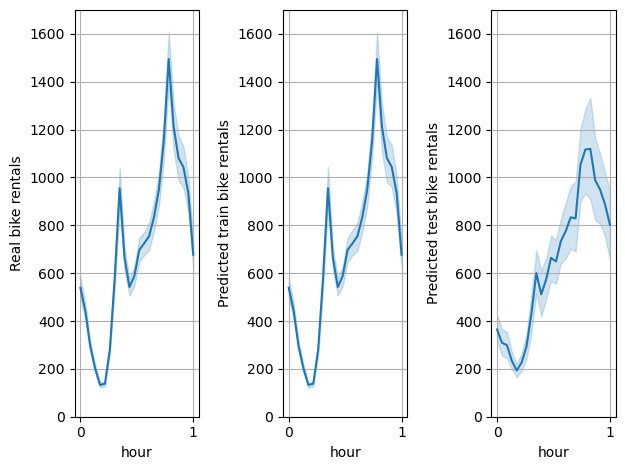

In [23]:
fig,ax = plt.subplots(1,3)

sax = sns.lineplot(data=X_train_final, x='hour', y=y_train, ax=ax[0])
sax.set(ylabel='Real bike rentals', ylim=(0,1700))
sax.grid()

sax = sns.lineplot(data=X_train_final, x='hour', y=y_train_pred, ax=ax[1])
sax.set(ylabel='Predicted train bike rentals', ylim=(0,1700))
sax.grid()

sax = sns.lineplot(data=X_test_final, x='hour', y=y_test_pred, ax=ax[2])
sax.set(ylabel='Predicted test bike rentals', ylim=(0,1700))
sax.grid()

plt.tight_layout()
plt.savefig('../plots/predict_hour.png', dpi=300)
plt.show()

Neighbours=2 score=0.7352848351889891
Neighbours=3 score=0.7552989133870393
Neighbours=4 score=0.7508512570501261
Neighbours=5 score=0.7436712381920508
Neighbours=6 score=0.738546049232323
Neighbours=7 score=0.7296742798085298
Neighbours=8 score=0.7186328956148794
Neighbours=9 score=0.7103642746984802
Neighbours=10 score=0.7082240393021149
Neighbours=11 score=0.6987634874247425
Neighbours=12 score=0.6951780651306614
Neighbours=13 score=0.6905328519298806
Neighbours=14 score=0.686628697401328
Neighbours=15 score=0.6823504268779597
Neighbours=16 score=0.6795721158118687
Neighbours=17 score=0.6777163177940663
Neighbours=18 score=0.6735338021760668
Neighbours=19 score=0.6706903783768814
Neighbours=20 score=0.6677371870499478
Neighbours=21 score=0.6650247707283776
Neighbours=22 score=0.663405982166902
Neighbours=23 score=0.6629762541603864
Neighbours=24 score=0.6614525522153909
Neighbours=25 score=0.6597994114953311
Neighbours=26 score=0.6576322471501861
Neighbours=27 score=0.65646728735843

Text(0, 0.5, 'R2')

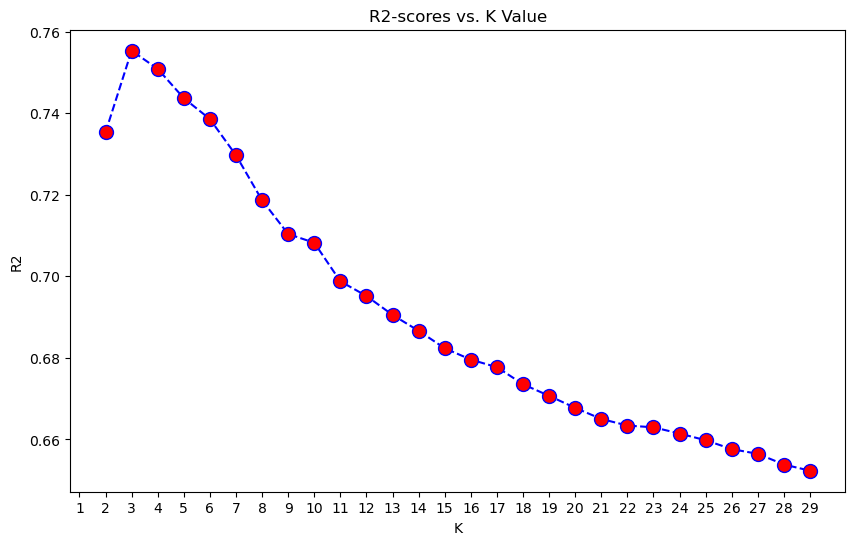

In [24]:
scores = []
for k in range(2,30):
    model = KNeighborsRegressor(n_neighbors=k)

    model.fit(X_train_final, y_train)
   # knn_models.append(model)

    score = model.score(X_test_final, y_test)
    scores.append(score)
    print(f'Neighbours={k} score={score}')

plt.figure(figsize=(10,6))
plt.plot(range(2,30), scores, color = 'blue', linestyle='dashed',
         marker='o', markerfacecolor='red', markersize=10)
plt.title('R2-scores vs. K Value')
plt.xticks(range(1,30))
#plt.gca().invert_yaxis()
plt.xlabel('K')
plt.ylabel('R2')

##### So the best k value is 3 !!

In [ ]:
def plot_k(X_train, X_test, y_train, y_test, max_k=20):
    '''
    Creates a plot with the r2-score on the y-axis and
    the k-value on th x-axis to determine the best k-value.
    
    Args:
        X_train: Independent variables of the training set
        X_test:  Dependent variables of the training set
        y_train: Independent variables of the test set
        y_test:  Dependent variable of the test set
        max_k:   Maximal k value to exermine
    '''
    
    scores = []
    
    for k in range(2,max_k+1):
        mod = KNeighborRegressor(n_neighbors=k)
        mod.fit(X_train, y_train)
        score = mod.score(X_test, y_test)
        scores.append(score)
        
    plt.figure(figsize=(8,6))
    plt.plot(range(2, max_k+1), scores, color='blue'
            marker='o', makerfacecolor='red', markersize=10)
    plt.title('R2-score vs. K-value')
    plt.xticks(range(1, max_k+1))
    plt.xlabel('k')
    plt.ylabel('r2')